In [5]:
from utils import *
from models import *
from training import *

hpc = False
labs = False
paperspace = True

if hpc:
    main_data_path = "/rds/general/user/hsa22/ephemeral/Brain_MINDS/model_data"
    main_logs_path = "/rds/general/user/hsa22/ephemeral/Brain_MINDS/predicted_streamlines"
elif labs:
    main_data_path = "/media/hsa22/Expansion/Brain_MINDS/model_data"
    main_logs_path = "/media/hsa22/Expansion//Brain_MINDS/predicted_streamlines"
elif paperspace:
    main_data_path = "/notebooks/model_data_w_resize"
    main_logs_path = "/notebooks/predicted_streamlines"
else:
    main_data_path = "D:\\Brain-MINDS\\model_data"
    main_logs_path = "D:\\Brain-MINDS\\predicted_streamlines"

streamline_arrays_path = os.path.join(main_logs_path, "streamline_predictions", "efficientnet")
training_log_folder = os.path.join(main_logs_path, "training_logs")
model_folder = os.path.join(main_logs_path, "models", "efficientnet")

check_output_folders(streamline_arrays_path, "streamline arrays", wipe=False)
check_output_folders(training_log_folder, "training_log_folder", wipe=False)
check_output_folders(model_folder, "model_folder", wipe=False)

training_log_path = os.path.join(training_log_folder, "efficientnet.csv")
model_filename = os.path.join(model_folder, "efficientnet.h5")

# Create the config dictionary
config = {

    ####### Model #######
    "model_name" : "efficientnet", # Model name
    "input_nc" : 1,
    "combination" : True, # Combination
    "task" : "classification", # Task
    "hidden_size" : 32, # number of neurons
    "depthwise_conv" : True, # Depthwise convolution
    "library_opt" : True, # Use stuff from torch_optim

    ####### Training #######
    "n_epochs" : 50, # Number of epochs
    "loss" : "negative_log_likelihood_loss", # Loss function
    "optimizer" : "Adam", # Optimizer
    "evaluation_metric" : "negative_log_likelihood_loss", # Evaluation metric
    "shuffle_dataset" : True,
    "separate_hemisphere" : False,
    "cube_size" : 3, # cube size
    "save_best" : True, # Save best model
    "overfitting" : False, # Overfitting

    ####### Data #######
    "main_data_path" : main_data_path, # Data path
    "training_log_path" : training_log_path, # Training log path
    "model_filename" : model_filename, # Model filename
    "streamline_arrays_path" : streamline_arrays_path, # Path to the streamlines array
    "batch_size" : 1, # Batch size
    "validation_batch_size" : 1, # Validation batch size
    "num_streamlines" : 10, # Number of streamlines to consider from each site
    
    ####### Parameters #######
    "initial_learning_rate" : 1e-2, # Initial learning rate
    "early_stopping_patience": None, # Early stopping patience
    "decay_patience": None, # Learning rate decay patience
    "decay_factor": None, # Learning rate decay factor
    "min_learning_rate": 0.1, # Minimum learning rate
    "save_last_n_models": 10, # Save last n models

    ####### Misc #######
    "skip_val" : False, # Skip validation
    "training_type" : "streamline", # Training type
    "tck_type" : "trk" # TCK type

}

In [6]:
dataset = StreamlineDataset(main_data_path, num_streamlines=config["num_streamlines"], transforms=None, train=True, tck_type=config["tck_type"],
                            task=in_config("task", config, "classification"))

# Get general parameters
n_gpus = config["n_gpus"] if "n_gpus" in config else 1
n_workers = config["n_workers"] if "n_workers" in config else 1
pin_memory = config["pin_memory"] if "pin_memory" in config else False
prefetch_factor = config["prefetch_factor"] if "prefetch_factor" in config else 1
amp = config["amp"] if "amp" in config else False
save_best = config["save_best"] if "save_best" in config else False
save_every_n_epochs = config["save_every_n_epochs"] if "save_every_n_epochs" in config else None
save_last_n_models = config["save_last_n_models"] if "save_last_n_models" in config else None
verbose = config["verbose"] if "verbose" in config else 1

In [7]:
# Get default collate
from torch.utils.data.dataloader import default_collate
collate_fn = default_collate

# Define the split size
proportions = [.75, .10, .15]
lengths = [int(p * len(dataset)) for p in proportions]
lengths[-1] = len(dataset) - sum(lengths[:-1])

# Split the data
seed = torch.Generator().manual_seed(42)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, lengths, generator=seed)
    
# Define the training loader
train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=config["batch_size"],
                                            shuffle=config["shuffle_dataset"],
                                            num_workers=n_workers,
                                            collate_fn=collate_fn,
                                            pin_memory=pin_memory,
                                            prefetch_factor=prefetch_factor)

# Define the validation loader
val_loader = torch.utils.data.DataLoader(val_set,
                                        batch_size=config["batch_size"],
                                        shuffle=config["shuffle_dataset"],
                                        num_workers=n_workers,
                                        collate_fn=collate_fn,
                                        pin_memory=pin_memory,
                                        prefetch_factor=prefetch_factor)

# Define the test loader
test_loader = torch.utils.data.DataLoader(test_set,
                                            batch_size=config["batch_size"],
                                            shuffle=config["shuffle_dataset"],
                                            num_workers=n_workers,
                                            collate_fn=collate_fn,
                                            pin_memory=pin_memory,
                                            prefetch_factor=prefetch_factor)

In [8]:
# Get the next batch from the train loader
(wmfod, streamlines, labels) = next(iter(train_loader))

print("wmfod.shape:", wmfod.shape)
print("streamlines.shape:", streamlines.shape)
print("labels.shape:", labels.shape)

wmfod.shape: torch.Size([1, 45, 128, 178, 115])
streamlines.shape: torch.Size([1, 10, 40, 3])
labels.shape: torch.Size([1, 10, 39])


In [23]:
# Correlation study between each coordinate in a streamline

# Choose which streamline to look at
streamline_chosen = 0

# Define the indices of the streamlines
batch_idx = 0
streamline_idx = 1
node_idx = 2
node_coord_idx = 3

# Create a list to hold the streamlines
streamlines_list = []

# For every streamline
for streamline in range(streamlines.shape[streamline_idx]):
    
    # Create list to hold the coordinates of the streamline
    streamline_coords = []
    
    # For every point in the streamline
    for point in range(streamlines.shape[node_idx]):

        # Get the current point from the streamline of all batches
        streamline_node = streamlines[:, streamline, point].cpu().detach().numpy()

        # Get the x, y, z coordinate into a list
        curr_coord = np.array([streamline_node[:, 0], streamline_node[:, 1], streamline_node[:, 2]])

        # Append the current coordinate to the list of coordinates
        streamline_coords.append(curr_coord)
    
    # Append the streamline coords to the streamlines list
    streamlines_list.append(streamline_coords)

# Convert the list of coordinates into a numpy array
streamlines_list = np.transpose(np.array(streamlines_list).squeeze(-1), axes=(0, 2, 1))

print(streamlines_list.shape)

(10, 3, 40)


In [24]:
# Create list of correlations
correlation_list = []

for streamline in range(streamlines_list.shape[0]):
    
    # Find the correlation between them for every streamline
    correlation = np.corrcoef(streamlines_list[streamline])
    
    # Append to list
    correlation_list.append(correlation)
    
# Turn into numpy array
correlation_list = np.array(correlation_list)

print(correlation_list.shape)

(10, 3, 3)


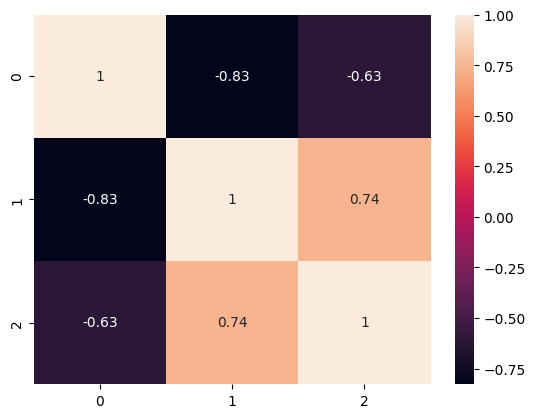

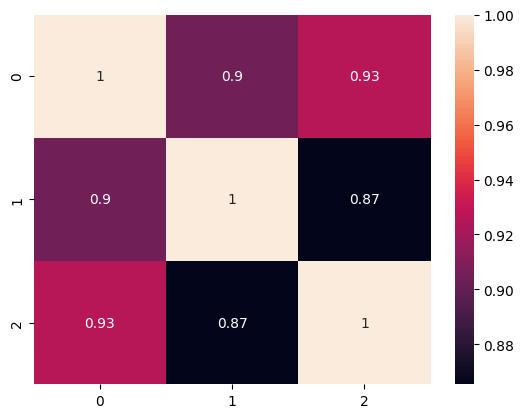

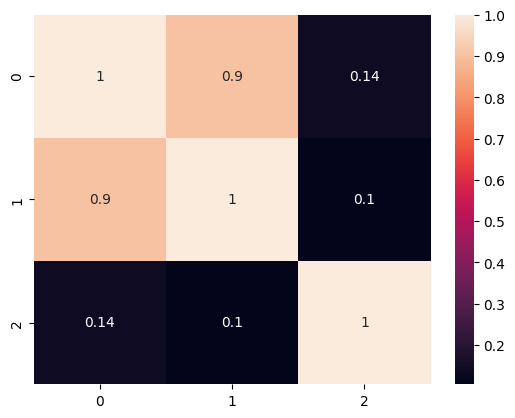

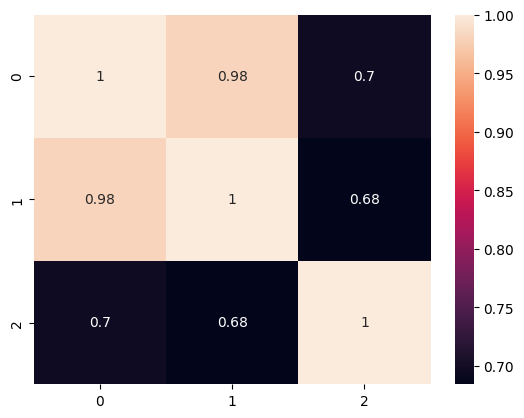

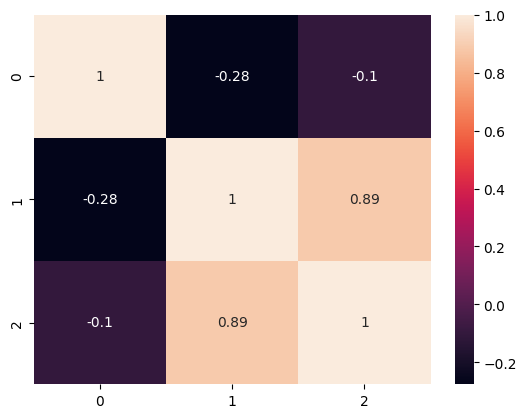

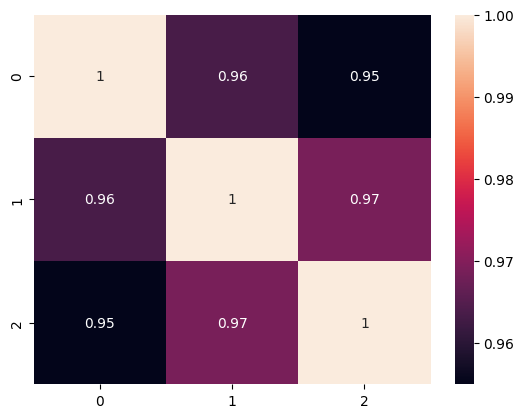

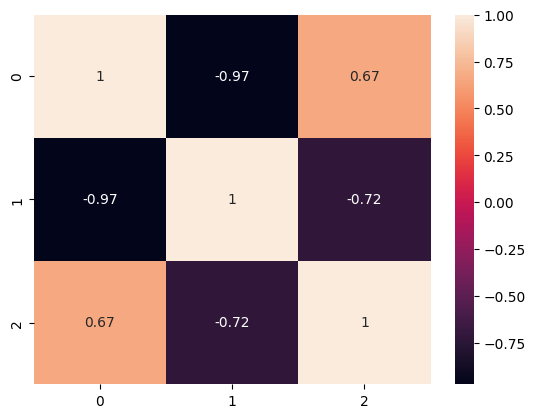

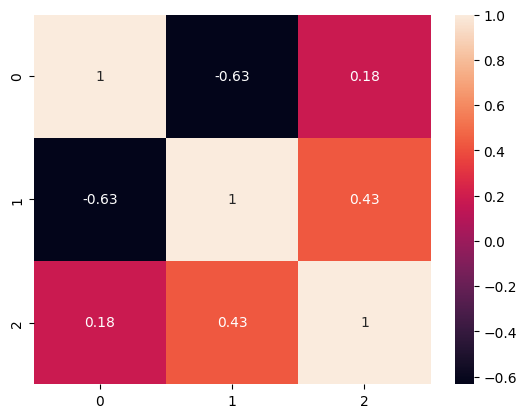

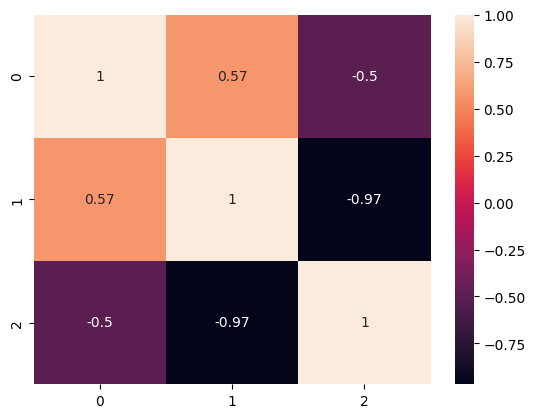

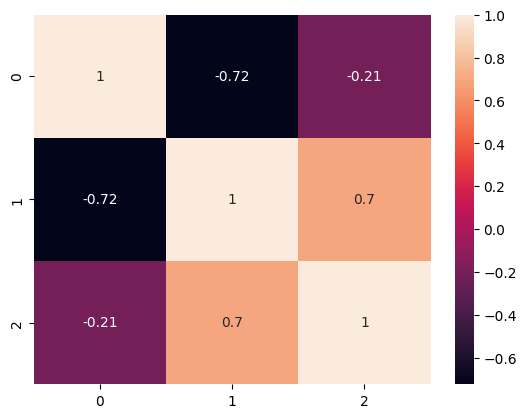

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Print every correlation in the list
for correlation in correlation_list:
    sns.heatmap(correlation, annot=True)
    plt.show()